# Provider Referral Project - Summer Demo
##### By Zach Garfinkel
---

## Project Overview
- Problem: A significant number of claims (40-50%) have the referring provider missing
- Goal: To accurately predict referring providers for claims with missing provider input
- Purpose: To better understand referral patterns, discover useful insights to help clients
- Approach: To use machine learning techniques (Natural Language Processing, Neural Network)
- Obstacles: Defining a referral, Getting provider coverage, Memory, Time
- Versions: 1) 60k vocab original, 2) 120k vocab, simply bigger, 3) 335k vocab, huge, 4) 155k vocab, confined to MI/MA

### Outline:
- 1) Language Model / Vocab / Embeddings
- 2) Exploration: Clustering / Taxonomy
- 3) The Concatenated Model
- 4) Optimization
- 5) Evaluation  
---

# 1) The Language Model
- Needed for the model to "understand the meaning" of each "word" (npi, icd, cpt)
- After training the model on a large body of text, we can extract the embeddings for each token in the vocab
- One of our main issues was managing the vocab size/keeping it within memory
    - We had to adjust the min_freq and max_vocab parameters to get it just right
- The attempts
    - 60k, 120k, 335k, 155k
    - reducing the batch size helped with memory issues (64 to 32 to 8)
    - training time for 60k was 4 hours, while it took 17 hours for the largest size

In [ ]:
# IMPORTS

from fastai import *
from fastai.text import *
from fastai.tabular import *

import numpy as np
import pandas as pd
import math
import random
import time
import re

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from numpy.linalg import norm as n
from scipy.spatial.distance import cosine

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('fivethirtyeight')

In [5]:
# READ IN DATASET

patient_history = pd.read_csv('patient-history.csv', sep=',')
patient_history = patient_history.drop(['Unnamed: 0','index'], axis=1)
print(patient_history.shape)
patient_history.head()

(195948, 1)


,final_input
0,M 44.0 0016A000005I9DfQAK 1437106028 cpt_5231 ...
1,F 74.0 fac_missing 1528385002 cpt_9921 fac_mis...
2,F 25.0 0016A000004sUmQQAU rend_npi_missing cpt...
3,M 74.0 fac_missing rend_npi_missing cpt_9924 i...
4,F 10.0 fac_missing 1154368751 cpt_8788 cpt_990...


In [ ]:
# MAKE DATABUNCH

data = TextLMDataBunch.from_df(path='patient-history-databunch-v2',
                               train_df=patient_history.iloc[:160000,:],
                               valid_df=patient_history.iloc[160000:,:],
                               min_freq=15,
                               max_vocab=120000,
                               text_cols=0)

In [64]:
# MAKE LEARNER

learner = language_model_learner(data=data, arch=AWD_LSTM, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


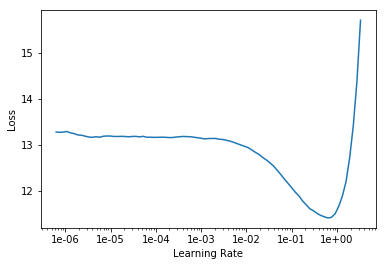

In [65]:
# EXAMINE LEARNING RATE / LOSS FUNCTION

learner.lr_find()
learner.recorder.plot()

In [66]:
# TRAIN LANGUAGE MODEL

learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,7.877154,7.373117,0.136324,5:12:34


In [11]:
# CREATE DATAFRAME OF EMBEDDINGS

encoder = list(lm_learner.model.children())[0]
weights = np.array(encoder.encoder.weight)
vocab = lm_learner.data.vocab

embedding_df = pd.DataFrame(weights, index=vocab.itos)
embedding_df[:20]

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
Word,,,,,,,,,,,,,,,,,,,,,
xxunk,0.422239,0.110524,0.188300,-0.177970,-0.862027,-1.308080,0.032377,1.902311,-0.166565,0.362732,...,-0.245860,-0.256663,-0.425380,0.081062,-0.506805,0.032340,0.059178,-0.627671,-0.085538,-0.400664
xxpad,-0.041045,0.184301,0.281527,0.084964,-0.309048,-1.579008,-0.084721,1.717358,-0.230417,-0.300896,...,0.190348,-0.095658,-0.085118,-0.006961,-0.722369,-0.080604,0.098516,-0.124282,-0.058556,-0.645861
xxbos,-0.616143,0.120165,-0.091013,-0.249598,0.297666,-1.581050,-0.427972,2.732010,-0.201345,-0.319570,...,-0.941001,-0.009987,-0.101303,0.446103,-0.447083,0.176097,-0.285198,-0.178414,-0.005895,0.223981
xxeos,-0.544649,0.462329,0.718794,-0.104883,-0.884738,-1.610312,-0.430079,1.065382,-0.023277,-0.519198,...,0.706062,-0.344047,-0.187079,0.042907,-0.377680,-0.221753,0.229837,-0.053473,-0.230581,-0.841908
xxfld,-0.544649,0.462329,0.718794,-0.104883,-0.884738,-1.610312,-0.430079,1.065382,-0.023277,-0.519198,...,0.706062,-0.344047,-0.187079,0.042907,-0.377680,-0.221753,0.229837,-0.053473,-0.230581,-0.841908
xxmaj,-0.922178,0.794679,1.097687,-0.270532,-1.782546,-1.502074,-0.754050,1.099850,0.081121,-0.542252,...,1.530832,-0.396039,-0.199384,0.119937,-0.347506,-0.428031,0.320032,0.001704,-0.406432,-0.999577
xxup,-0.865232,0.783585,1.181472,-0.309452,-1.714272,-1.356249,-0.555922,1.100539,0.037143,-0.374572,...,1.522549,-0.440990,-0.025803,0.214568,-0.349500,-0.402396,0.334581,0.089446,-0.372901,-0.852796
xxrep,-0.213603,0.232182,0.598472,0.131084,-0.332255,-1.637180,0.165517,1.315383,-0.289920,-0.376631,...,0.089283,0.433845,-0.060299,0.045338,-0.799803,0.201127,-0.081693,0.084675,-0.207263,-0.185430
xxwrep,-0.281963,0.501947,0.247711,-0.010929,-0.664183,-1.309011,0.239148,1.982515,-0.132457,-0.235624,...,0.129917,0.389554,0.060644,0.371411,-0.338059,-0.026668,0.031215,-0.211271,-0.342834,-0.691713


---
# 2) Exploration: Clustering / Taxomomy
- Testing to see if the model's generated vectors were actually good
- Used the cosine distance metric
- Joined with the taxonomy table for extra insights

In [ ]:
# FUNCTION TO FIND CLOSEST TOKENS IN EMBEDDING SPACE

def fast_closest(code:str, df:pd.DataFrame, k:int):
    '''Cosine Distance'''
    distances = np.arccos(np.round(np.dot(df.loc[code]/n(df.loc[code]),(df.values/n(df.values,axis=1)[:,None]).T),10))
    close_df = pd.DataFrame({'Word':df.index, 'Distance':distances*180/math.pi})
    close_df = close_df.sort_values(by=['Distance'])
    return close_df.head(k)

In [8]:
fast_closest('cpt_9920',5)

,Word,Distance
53,cpt_9920,0.000000
14,cpt_9921,13.167523
376,cpt_9924,13.969048
575,cpt_9902,21.490436
445,cpt_9079,22.391923


In [21]:
# EXTRACTING PROVIDER EMBEDDINGS FROM VOCAB

pros = []
for i in np.arange(len(vocab.itos)):
    pros.append(re.findall('^pro_\d{10}',vocab.itos[i]))  
providers = []
for i in np.arange(len(pros)):
    if len(pros[i]) == 1:
        providers.append(pros[i][0])
provider_embeddings = embedding_df.reindex(providers)

In [ ]:
# FAST DISTANCE FUNCTIONS FOR PROVIDERS AND SPECIALTIES

def closest_providers(code:int, df:pd.DataFrame, k:int):
    '''Returns closest k providers by cosine distance, df must be form index=providers, values=embeddings'''
    distances = np.arccos(np.round(np.dot(df.loc[code]/n(df.loc[code]),(df.values/n(df.values,axis=1)[:,None]).T),10))
    close_df = pd.DataFrame({'Provider':df.index, 'Specialty':np.array(provider_embeddings.iloc[:,1]),'Distance':distances*180/math.pi})
    close_df = close_df.sort_values(by=['Distance'])
    return close_df.head(k)

def closest_specialties(code:str, df:pd.DataFrame, k:int):
    '''Returns closest k specialties by cosine distance, df must be form index=specialties, values=embeddings'''
    distances = np.arccos(np.round(np.dot(df.loc[code]/n(df.loc[code]),(df.values/n(df.values,axis=1)[:,None]).T),10))
    close_df = pd.DataFrame({'Specialty':df.index, 'Distance':distances*180/math.pi})
    close_df = close_df.sort_values(by=['Distance'])
    return close_df.head(k)

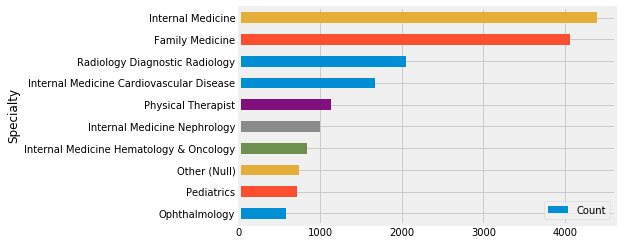

In [12]:
# PLOTTING DISTRIBUTION OF SPECIALTIES

specialties = pd.DataFrame(provider_embeddings['Specialty']).fillna('Other (Null)')
unique_specs = np.unique(np.array(specialties['Specialty']), return_counts=True)
spec_dist = pd.DataFrame({'Specialty':unique_specs[0],'Count':unique_specs[1]})
top_10_specs = spec_dist[spec_dist['Count'] >= 500].sort_values(by=['Count'], ascending=True)
top_10_specs.plot.barh('Specialty','Count')

In [109]:
closest_providers(1609119254, pro_emb, 5)

,Provider,Specialty,Distance
29085,1609119254,Family Medicine,0.000000
22585,1659422004,Nurse Practitioner Gerontology,1.905980
10165,1508876848,Pain Medicine Interventional Pain Medicine,2.018081
23928,1568440394,Thoracic Surgery (Cardiothoracic Vascular Surg...,2.069496
27248,1033254446,Physical Therapist,2.147567


In [14]:
closest_specialties('Family Medicine',top_spec_embeddings,10)

,Specialty,Distance
1,Family Medicine,0.000000
0,Internal Medicine,0.296806
34,General Practice,0.348647
27,Surgery,0.402042
6,Internal Medicine Hematology & Oncology,0.427893
9,Psychiatry,0.452230
23,Internal Medicine Geriatric Medicine,0.587479
5,Internal Medicine Nephrology,0.623029
41,Physician Assistant,0.710151
37,Nurse Practitioner,0.754479


In [ ]:
# GET FIRST LETTERS OF EACH CPT CODE

def first_letter(code:str):
    letters = []
    match = re.findall('^cpt_(.)...', code)
    if len(match) == 1:
        letters.append(match[0])
    else:
        letters.append(-1)
    return letters

first_letters = [first_letter(i) for i in vocab]

In [13]:
# PCA and T-SNE

xs = embeddings.values
ys = embeddings.index

pca = PCA(n_components=2)
pca_result = pca.fit_transform(xs)

pca_df = pd.DataFrame(columns = ['pca1','pca2'])
pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df.index = embeddings.index
pca_df['Class'] = list(np.squeeze(first_letters))
cpt_pca = pca_df[pca_df['Class'] != '-1'].iloc[:,:2].values

tsne_result = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=1000, learning_rate=200).fit_transform(cpt_pca)
tsne_df = pd.DataFrame(columns = ['tsne1','tsne2'])
tsne_df['tsne1'] = tsne_result[:,0]
tsne_df['tsne2'] = tsne_result[:,1]

tsne_df['Class'] = list(cpt_df['Class'])
tsne_df.index = cpt_df.index

In [53]:
# CLUSTER FUNCTION THAT SHOWS CLASSES AS DIFFERENT COLORS

def cluster_scatter(df:pd.DataFrame):

    classes = np.unique(df.iloc[:,2])
    num_classes = len(classes)
    palette = np.array(sns.color_palette("hls", num_classes))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(df.iloc[:,0], df.iloc[:,1], lw=0, s=40, c=palette)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(len(classes[:10])):

        # Position of each label at median of data points.
        xtext, ytext = np.median(df[df.iloc[:,2]==classes[i]].iloc[:,:2], axis=0)
        txt = ax.text(xtext, ytext, classes[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return plt, f, ax, sc, txts

(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>,
 <Figure size 576x576 with 1 Axes>,
 [Text(-7.41805,-17.5586,'0'),
  Text(0.860728,12.8136,'1'),
  Text(-4.25782,-18.5718,'2'),
  Text(-4.71011,-4.51607,'3'),
  Text(-3.11255,-20.999,'4'),
  Text(-4.54696,-12.7768,'5'),
  Text(-3.12337,-18.5724,'6'),
  Text(7.62774,19.3083,'7'),
  Text(-1.30134,20.0426,'8'),
  Text(10.61,19.0043,'9')])

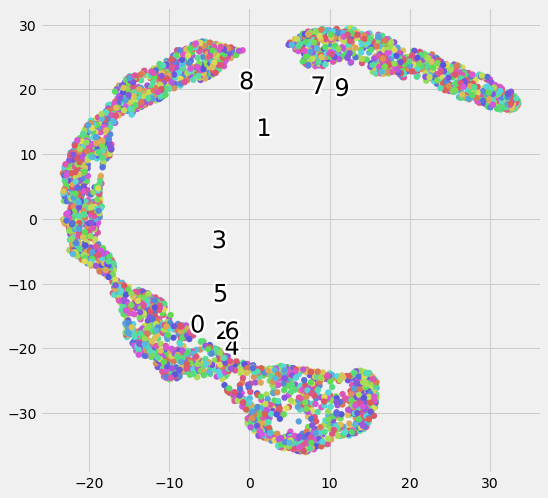

In [71]:
# PLOTTING RESULTS

cluster_scatter(tsne_df)

---
# 3) The Concat Model (The Classifier)
- While the LM on its own is helpful, it still doesn't allow us to classify anythibng
- Making use of the embedding vectors from the language model and the capabilities of a text classifier, we created a multi-input model
    - inspired by InstaCart's shopping route problem
- The Input to the Model is 3 parts
    1) The patient's history (the patient from the claim)
    2) The 400-length embedding of the candidate provider
    3) The 400-length embedding of the patient's current provider
- The Target is 0 or 1 (binary), representing "no" or "yes" that the candidate provider listed is the target provider <br>

- Here you'll see the coverage issues we ran into along the way

In [8]:
# CREATE AND SHOW TRAIN AND VALID CLASSIFICATION SETS

train = pd.read_csv('pd_classification_train_v3.csv')
valid = pd.read_csv('pd_classification_val_v3.csv')
    
train['set'] = 'train'
valid['set'] = 'valid'
 
train_valid = pd.concat([train, valid])
train_valid = train_valid.reset_index()
train_valid = train_valid.drop(['index','Unnamed: 0'], axis=1)
train_valid.head(7)

,patient_emb_input,target,candidate_providers,binary_target,cur_provider,set
0,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1306287024,0,pro_1770609190,train
1,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1477787208,0,pro_1770609190,train
2,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1205165974,0,pro_1770609190,train
3,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1639130248,0,pro_1770609190,train
4,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1912956319,1,pro_1770609190,train
5,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1770609190,0,pro_1770609190,train
6,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_no_candidate,0,pro_1770609190,train


In [11]:
# JOIN TRAIN_VALID WITH EMBEDDINGS DATAFRAME

train_embeddings = pd.merge(train, embeddings, how='left', left_on='candidate_providers', right_index=True)
valid_embeddings = pd.merge(valid, embeddings, how='left', left_on='candidate_providers', right_index=True)

train_embeddings[:7]

,Unnamed: 0,patient_emb_input,target,candidate_providers,binary_target,cur_provider,set,0,1,2,...,390,391,392,393,394,395,396,397,398,399
0,0,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1306287024,0,pro_1770609190,train,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1477787208,0,pro_1770609190,train,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1205165974,0,pro_1770609190,train,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1639130248,0,pro_1770609190,train,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1912956319,1,pro_1770609190,train,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_1770609190,0,pro_1770609190,train,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,M 19.0 fac_4skzfqau pro_1306287024 cpt_9921 ic...,pro_1912956319,pro_no_candidate,0,pro_1770609190,train,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# CREATE CONCAT DF, THE FINAL INPUT INTO THE MODEL

candidate_embeddings = pd.merge(train_valid, provider_embeddings, how='left', left_on='candidate_providers', right_index=True).iloc[:,6:].fillna(1)
candidate_embeddings = pd.DataFrame(data=candidate_embeddings.values, columns=[f'a_{i}' for i in range(400)])
current_embeddings = pd.merge(train_valid, provider_embeddings, how='left', left_on='cur_provider', right_index=True).iloc[:,6:].fillna(1)
current_embeddings = pd.DataFrame(data=current_embeddings.values, columns=[f'b_{i}' for i in range(400)])
    
concat_df = pd.concat([train_valid, candidate_embeddings, current_embeddings], axis=1)
concat_df['Distance'] = get_distances(candidate_embeddings.values, current_embeddings.values)

val_idxs = range(list(concat_df[concat_df['set'] == 'valid'].index)[0],concat_df.shape[0])

concat_df.head()

,patient_emb_input,target,candidate_providers,cur_provider,set,binary_target,a_0,a_1,a_2,a_3,...,b_391,b_392,b_393,b_394,b_395,b_396,b_397,b_398,b_399,Distance
0,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_1114087988,pro_1144556499,train,0,-1.606925,-0.219466,-0.333673,-0.651046,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,3.096487
1,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_1427126978,pro_1144556499,train,1,-1.733992,-0.231210,-0.371799,-0.683031,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,3.251669
2,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_npi_missing,pro_1144556499,train,0,1.000000,1.000000,1.000000,1.000000,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,92.288429
3,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_1144556499,pro_1144556499,train,0,-1.579215,-0.213369,-0.409097,-0.701093,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,0.000000
4,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_no_candidate,pro_1144556499,train,0,1.000000,1.000000,1.000000,1.000000,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,92.288429


In [148]:
# THE CONCAT MODEL

class ConcatModel(nn.Module): 

    def __init__(self, tabular, text, layers, drops): 
        super().__init__() 

        self.tabular = tabular 
        self.text = text 

        layers_list = [] 
        activations = [nn.ReLU(inplace=True), ] * (len(layers)-2) + [None] 
        for n_in, n_out, p, actn in zip(layers[:-1], layers[1:], drops, activations): 
            layers_list += bn_drop_lin(n_in, n_out, p=p, actn=actn) 
        self.layers = nn.Sequential(*layers_list) 

    def forward(self, *x): 
        x_text = self.text(x[1])[0] 
        x_tab = self.tabular(*x[0]) 
        x = torch.add(x_tab, x_text) 
        
        return self.layers(x) 

class ConcatDataset(Dataset): 

    def __init__(self, x1, x2, y): self.x1, self.x2, self.y = x1, x2, y 
    def __len__(self): return len(self.y) 
    def __getitem__(self, i): return(self.x1[i], self.x2[i]), self.y[i] 

def tabtext_collate(batch):
    x, y = list(zip(*batch)) 
    x1, x2 = list(zip(*x))
    x1 = to_data(x1) 
    x1 = list(zip(*x1)) 
    x1 = torch.stack(x1[0]), torch.stack(x1[1]) 
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True) 
    return (x1,x2), y

def get_databunches(df, dep_var, vocab, path=Path.cwd(), bs=64): 
    
    val_idxs = range(list(df[df['set'] == 'valid'].index)[0],df.shape[0])
    
    tabular_db = (TabularList.from_df(df, cat_names=None, cont_names=list(df.columns[6:]))
                  .split_by_idx(val_idxs)
                  .label_from_df(cols=dep_var)
                  .databunch()) 

    text_db = (TextList.from_df(df, cols=['patient_emb_input'], vocab=vocab)
               .split_by_idx(val_idxs)
               .label_from_df(cols=dep_var)
               .databunch())

    train_ds = ConcatDataset(tabular_db.train_ds.x, text_db.train_ds.x, tabular_db.train_ds.y) 
    valid_ds = ConcatDataset(tabular_db.valid_ds.x, text_db.valid_ds.x, tabular_db.valid_ds.y) 

    train_sampler = SortishSampler(text_db.train_ds.x, lambda x: len(text_db.train_ds[x][0].data), bs=bs//2) 
    valid_sampler = SortSampler(text_db.valid_ds.x, key=lambda x: len(text_db.valid_ds[x][0].data)) 

    train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler, shuffle=False) 
    valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler) 

    data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=tabtext_collate, path=path) 

    return data, tabular_db, text_db

In [ ]:
# CREATING THE FINAL CLASSIFIER LEARNER

data, tabular_db, text_db = get_databunches(df=full_df,
                                            val_idxs=val_idxs,
                                            dep_var='binary_target',
                                            path=Path.cwd(),
                                            bs=64)

tab_learner = tabular_learner(data=tabular_db, layers=[50]) 
text_learner = text_classifier_learner(data=text_db, arch=AWD_LSTM, drop_mult=.15, lin_ftrs=[50])
text_learner.load_encoder('lm_encoder-Copy1')

text_learner.model[-1].layers = text_learner.model[-1].layers[:-3] 
tab_learner.model.layers = tab_learner.model.layers[:-2] 
lin_layers = [50, 2] 
ps = [.15] 

model = ConcatModel(text=text_learner.model, layers=lin_layers, drops=ps, tabular=tab_learner.model) 

layer_groups = [nn.Sequential(*flatten_model(text_learner.layer_groups[0])),
                 nn.Sequential(*flatten_model(text_learner.layer_groups[1])),
                 nn.Sequential(*flatten_model(text_learner.layer_groups[2])),
                 nn.Sequential(*flatten_model(text_learner.layer_groups[3])),
                 nn.Sequential(*flatten_model(text_learner.layer_groups[4]) + flatten_model(model.tabular) + flatten_model(model.layers))]

learner = Learner(data, model, layer_groups=layer_groups)

---
# 4) Optimization
- There is still much work to be done redefining the problem and optimizing the learner
- While what it does is impressive, it has enormous room for improvement
<br>
- Arguably the biggest obstacle was provider coverage
- Here you can see the improvement (v4 below)
    - 26% --> 47% --> 73% of the rows have a candidate provider embedding
    - 41% --> 67% --> 98% of the rows have a current provider embedding

***Strategies used to optimize the model:***
   - 1. Cleaning up the language model text corpus (fewer xxunk, not including/including certain details, how far back)
   - 2. Using the npi_missing embedding as the "null" vector
   - 3. Confining the dataset **geographically**

In [22]:
new_concat.head()

,patient_emb_input,target,candidate_providers,cur_provider,set,binary_target,a_0,a_1,a_2,a_3,...,b_391,b_392,b_393,b_394,b_395,b_396,b_397,b_398,b_399,Distance
0,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_1114087988,pro_1144556499,train,0,-1.606925,-0.219466,-0.333673,-0.651046,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,3.096487
1,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_1427126978,pro_1144556499,train,1,-1.733992,-0.231210,-0.371799,-0.683031,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,3.251669
2,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_npi_missing,pro_1144556499,train,0,NaN,NaN,NaN,NaN,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,92.288429
3,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_1144556499,pro_1144556499,train,0,-1.579215,-0.213369,-0.409097,-0.701093,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,0.000000
4,F 80.0 fac_missing pro_1114087988 cpt_g046 fac...,pro_1427126978,pro_no_candidate,pro_1144556499,train,0,NaN,NaN,NaN,NaN,...,0.305296,0.186125,0.234624,3.135921,0.394461,-0.739759,-0.53155,0.467753,-1.488441,92.288429


In [17]:
def get_stats(df):
    curr_providers = np.unique(list(df.cur_provider))
    cand_providers = np.unique(list(df.candidate_providers))
    
    print(len(list(provider_embeddings.index)),'providers are represented in the vocab')

    print(np.round(np.mean(df['a_0'] != 1)*100,2),'% of the rows have a candidate provider embedding')
    print(np.round(np.mean(df['b_0'] != 1)*100,2),'% of the rows have a current provider embedding')

    print(len(cand_providers),'unique candidate providers exist in the full dataset')
    print(len(curr_providers),'unique current providers exist in the full dataset')
    
    print(np.round(8896/47225*100, 2), '% candidates = pro_no_candidate')
    print(np.round(np.mean([True if i=='pro_no_candidate' else False for i in list(concat_df[val_idxs[0]:].iloc[:,1])])*100, 2), '% of the targets are pro_no_candidate')

In [137]:
#V2
get_stats(concat_df)

78577 providers are represented in the vocab
26.17 % of the rows have a candidate provider embedding
41.09 % of the rows have a current provider embedding
161531 unique candidate providers exist in the full dataset
46902 unique current providers exist in the full dataset


In [215]:
#V3
get_stats(concat_df)

258090 providers are represented in the vocab
47.57 % of the rows have a candidate provider embedding
67.63 % of the rows have a current provider embedding
161531 unique candidate providers exist in the full dataset
46902 unique current providers exist in the full dataset
53.72 % of the targets are pro_no_candidate


In [167]:
#V4
get_stats(concat_df)

119684 providers are represented in the vocab
73.87 % of the rows have a candidate provider embedding
98.59 % of the rows have a current provider embedding
60117 unique candidate providers exist in the full dataset
20212 unique current providers exist in the full dataset
52.59 % of the targets are pro_no_candidate


*100% below by using the pro_npi_missing embedding for any missing providers, leaving no candidates without an embedding*

In [18]:
#V5?
get_stats(concat_df)

119684 providers are represented in the vocab
100.0 % of the rows have a candidate provider embedding
100.0 % of the rows have a current provider embedding
60117 unique candidate providers exist in the full dataset
20212 unique current providers exist in the full dataset
18.84 % candidates = pro_no_candidate
52.59 % of the targets are pro_no_candidate


---
# 5) Evaluation
- It is important with any model to constantly evaluate it so you can know how it is performing
- The way to do this in fastai is through their built in `get_preds()` function
    - It simply returns the probabilities it assigns the target classes (0 and 1) 
- I came up with a few custom metrics to see how it's doing
    - accuracy = for every single candidate in every single claim, did they guess the binary target correctly
    - correct candidate selected = per claim, was the correct candidate selected as the target

- Example
    - There are 4 candidate providers that could be the target (the true referring provider)
    - The model decides independent percentages for each of the candidates (i.e. not in relation to eachother)
    - It says it believes with x% certainty that each provider is the target
    - Let's say that the probabilities are 0.21, 0.03, 0.37, 0.65 for the four candidates
    - I chose the top one out of the claim bunch, assigned it a 1, and gave the rest 0's

- I used 2 techniques to evaluate these probabilities for each claim
    - Normalization
        - I looked at the model's average probability for each provider and used it as a baseline
        - e.g. if a provider is given a 0.3 probability but averages a 0.1 over the whole dataset, that is more meaningful than a 0.5 that averages a 0.6
    - Softmax
        - I used softmax on the probabilities for each claim so that they sum to 1 and can be generalized across claims
        - e.g. if a provider is given a 0.5 probability when there are 20 candidates, that is much more meaningful than a 0.5 with only 2 candidates
   

In [ ]:
preds = learner.get_preds()

In [166]:
def get_accuracy(preds=preds):
    
    concat_stats = concat_df[val_idxs[0]:].iloc[:,[0,1]]
    concat_stats['no cand target'] = [True if i=='pro_no_candidate' else False for i in list(concat_df[val_idxs[0]:].iloc[:,1])]
    concat_stats['cand exist'] = [False if i==1 else True for i in list(concat_df[val_idxs[0]:].iloc[:,6])]
    concat_stats['cur exist'] = [False if i==1 else True for i in list(concat_df[val_idxs[0]:].iloc[:,406])]
    concat_stats['num cands'] = pd.merge(concat_df[val_idxs[0]:], concat_df[val_idxs[0]:].iloc[:,[0,1]].groupby('patient_emb_input').count(), how='left',left_on='patient_emb_input', right_index=True)['target_y']
    concat_stats = concat_stats.reset_index().drop(['index'], axis=1)
    
    sampler_order = [i for i in learner.data.valid_dl.sampler]
    sorted_stats = concat_stats.reset_index().reindex(sampler_order).reset_index().drop(['level_0','index'], axis=1)
    
    probs = list(np.array(preds[0][:,1]))
    probs = [i + random.random()*1e-2 for i in probs] 
    actuals = np.array(preds[1])
    prob_df = pd.DataFrame({'patient_emb_input':list(sorted_stats['patient_emb_input']),'probs':probs,'labels':actuals})

    grouped_max = prob_df.groupby(by=['patient_emb_input']).max().reset_index()
    rejoined = pd.merge(left=prob_df, right=grouped_max, how='left', left_on='probs', right_on='probs')

    new_preds = np.array([abs(i-1) for i in list(rejoined['patient_emb_input_y'].isnull().astype(int))])
    
    accuracy = 1 - np.mean(abs(new_preds-actuals))
    print(np.round(accuracy*100,2), '% accuracy')
    
    prob_df['predictions'] = new_preds
    
    def per_bunch_acc(df):
        only_pos = df[df['labels'] == 1]
        acc = np.mean(list(only_pos['predictions']))
        return acc
    
    print(np.round((per_bunch_acc(prob_df)*100),2),'% correct candidate selected')
    
    full_stats = pd.concat([sorted_stats,prob_df], axis=1)
    
    for i in [True,False]:
        tf_df = full_stats[full_stats['no cand target'] == i]
        acc = 1 - np.mean(abs(np.array(tf_df['labels']) - np.array(tf_df['predictions'])))
        print(np.round(acc*100,2), '% accuracy when pro_no_candidate = target is', i)
        print(np.round((per_bunch_acc(tf_df)*100),2), '% correct candidate selected when pro_no_candidate = target is', i)
        
    for i in [True,False]:
        tf_df = full_stats[full_stats['cand exist'] == i]
        acc = 1 - np.mean(abs(np.array(tf_df['labels']) - np.array(tf_df['predictions'])))
        print(np.round(acc*100,2), '% accuracy when candidate has embedding is', i)
        
    for i in [True,False]:
        tf_df = full_stats[full_stats['cur exist'] == i]
        acc = 1 - np.mean(abs(np.array(tf_df['labels']) - np.array(tf_df['predictions'])))
        print(np.round(acc*100,2), '% accuracy when cur provider has embedding is', i)
        print(np.round((per_bunch_acc(tf_df)*100),2), '% correct candidate selected when cur provider has embedding', i)
        
    for i in [True,False]:
        tf_df = full_stats[(full_stats['cand exist'] == i) & (full_stats['cur exist'] == i)]
        acc = 1 - np.mean(abs(np.array(tf_df['labels']) - np.array(tf_df['predictions'])))
        print(np.round(acc*100,2), '% accuracy when cand provider and cur provider have embeddings is', i)
    
    num_cands = []
    num_cands_acc = []
    num_cands_correct = []
    for i in np.unique(full_stats['num cands'])[:13]:
        num_cands.append(i)
        tf_df = full_stats[full_stats['num cands'] == i]
        acc = 1 - np.mean(abs(np.array(tf_df['labels']) - np.array(tf_df['predictions'])))
        #print(np.round(acc*100,2), '% accuracy when number of candidates in claim is', i)
        num_cands_acc.append(np.round(acc*100,2))
        #print(np.round((per_bunch_acc(tf_df)*100),2), '% correct candidate selected when number of candidates =', i)
        num_cands_correct.append(np.round((per_bunch_acc(tf_df)*100),2))
    num_cands_df = pd.DataFrame(data=np.array([num_cands,num_cands_acc,num_cands_correct]).transpose())
    return num_cands_df.plot(0,[1,2],kind='bar')

79.33 % accuracy
45.14 % correct candidate selected
92.73 % accuracy when pro_no_candidate = target is True
81.57 % correct candidate selected when pro_no_candidate = target is True
64.48 % accuracy when pro_no_candidate = target is False
0.48 % correct candidate selected when pro_no_candidate = target is False
88.69 % accuracy when candidate has embedding is True
52.85 % accuracy when candidate has embedding is False
79.41 % accuracy when cur provider has embedding is True
45.41 % correct candidate selected when cur provider has embedding True
73.84 % accuracy when cur provider has embedding is False
25.62 % correct candidate selected when cur provider has embedding False
88.73 % accuracy when cand provider and cur provider have embeddings is True
68.86 % accuracy when cand provider and cur provider have embeddings is False


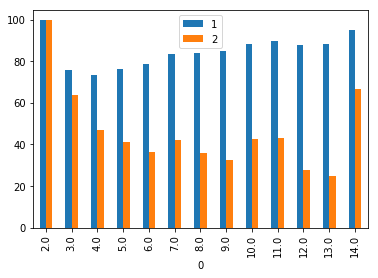

In [170]:
get_accuracy()

---
# The Final Product (as of now)

In [13]:
def read_datasets(frac=1):
    
    # Read Train/Valid sets, take desired fraction of datasets, combine into train_valid
    train = pd.read_csv('pd_classification_train_v4.csv')
    valid = pd.read_csv('pd_classification_val_v4.csv')
    
    train['set'] = 'train'
    valid['set'] = 'valid'
    
    targets_train = []
    for i in np.arange(len(train)):
        if (train.iloc[i,2] == train.iloc[i,3]):
            targets_train.append(1)
        else:
            targets_train.append(0)
        
    targets_val = []
    for i in np.arange(len(valid)):
        if (valid.iloc[i,2] == valid.iloc[i,3]):
            targets_val.append(1)
        else:
            targets_val.append(0)

    train['binary_target'] = targets_train
    valid['binary_target'] = targets_val
    
    train = train[:np.int(np.round((len(train)*frac)))]
    valid = valid[:np.int(np.round((len(valid)*frac)))]
    
    train_valid = pd.concat([train, valid])
    train_valid = train_valid.reset_index()
    train_valid = train_valid.drop(['index','Unnamed: 0'], axis=1)

    return train_valid

In [16]:
def get_language_model():
    lm_learner = load_learner(path=Path.cwd(),file='patient_v3_export.pkl')
    vocab = lm_learner.data.vocab
    weights = np.array(list(lm_learner.model.children())[0].encoder.weight)
    return vocab, weights

In [17]:
def get_provider_embeddings(weights, vocab):
    
    #Use regex to find all 400-length provider embeddings
    pros = []
    for i in np.arange(len(vocab.itos)):
        pros.append(re.findall('^pro_\d{10}',vocab.itos[i]))
    
    providers = []
    for i in np.arange(len(pros)):
        if len(pros[i]) == 1:
            providers.append(pros[i][0])
            
    embs = pd.DataFrame(data=weights, index=vocab.itos)
    provider_embeddings = embs.reindex(providers)
    
    return provider_embeddings

In [18]:
def get_distances(d1, d2):
    #Returns distances for distance column
    distances = np.squeeze(np.arccos(np.round(np.sum(np.multiply(d1, d2), axis=1)[:,None]/np.multiply(n(d1, axis=1)[:,None],n(d2, axis=1)[:,None]),5)))
    distances = distances*180/math.pi
    return distances

In [19]:
def make_dict(cols:list, embs:list):
    assert len(cols) == len(embs)
    dicty = {cols[i]: embs[i] for i in np.arange(len(embs))}
    return dicty

In [20]:
def get_concat_df():

    # Makes final df to feed to concat model
    candidate_embeddings = pd.merge(train_valid, provider_embeddings, how='left', left_on='candidate_providers', right_index=True).iloc[:,6:].fillna(make_dict(np.arange(400), list(weights[10])))
    candidate_embeddings = pd.DataFrame(data=candidate_embeddings.values, columns=[f'a_{i}' for i in range(400)])
    current_embeddings = pd.merge(train_valid, provider_embeddings, how='left', left_on='cur_provider', right_index=True).iloc[:,6:].fillna(make_dict(np.arange(400), list(weights[10])))
    current_embeddings = pd.DataFrame(data=current_embeddings.values, columns=[f'b_{i}' for i in range(400)])
    
    concat_df = pd.concat([train_valid, candidate_embeddings, current_embeddings], axis=1)
    #concat_df['Distance'] = get_distances(candidate_embeddings.values, current_embeddings.values)
    
    val_idxs = range(list(concat_df[concat_df['set'] == 'valid'].index)[0],concat_df.shape[0])
    
    return concat_df, val_idxs

In [21]:
class ConcatModel(nn.Module): 

    def __init__(self, tabular, text, layers, drops): 
        super().__init__() 

        self.tabular = tabular 
        self.text = text 

        layers_list = [] 
        activations = [nn.ReLU(inplace=True), ] * (len(layers)-2) + [None] 
        for n_in, n_out, p, actn in zip(layers[:-1], layers[1:], drops, activations): 
            layers_list += bn_drop_lin(n_in, n_out, p=p, actn=actn) 
        self.layers = nn.Sequential(*layers_list) 

    def forward(self, *x): 
        x_text = self.text(x[1])[0] 
        x_tab = self.tabular(*x[0]) 
        x = torch.add(x_tab, x_text) 
        
        return self.layers(x) 

class ConcatDataset(Dataset): 

    def __init__(self, x1, x2, y): self.x1, self.x2, self.y = x1, x2, y 
    def __len__(self): return len(self.y) 
    def __getitem__(self, i): return(self.x1[i], self.x2[i]), self.y[i] 

def tabtext_collate(batch):
    x, y = list(zip(*batch)) 
    x1, x2 = list(zip(*x))
    x1 = to_data(x1) 
    x1 = list(zip(*x1)) 
    x1 = torch.stack(x1[0]), torch.stack(x1[1]) 
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True) 
    return (x1,x2), y

def get_databunches(df, dep_var, vocab, path=Path.cwd(), bs=64): 
    
    val_idxs = range(list(df[df['set'] == 'valid'].index)[0],df.shape[0])
    
    tabular_db = (TabularList.from_df(df, cat_names=None, cont_names=list(df.columns[6:]))
                  .split_by_idx(val_idxs)
                  .label_from_df(cols=dep_var)
                  .databunch()) 

    text_db = (TextList.from_df(df, cols=['patient_emb_input'], vocab=vocab)
               .split_by_idx(val_idxs)
               .label_from_df(cols=dep_var)
               .databunch())

    train_ds = ConcatDataset(tabular_db.train_ds.x, text_db.train_ds.x, tabular_db.train_ds.y) 
    valid_ds = ConcatDataset(tabular_db.valid_ds.x, text_db.valid_ds.x, tabular_db.valid_ds.y) 

    train_sampler = SortishSampler(text_db.train_ds.x, lambda x: len(text_db.train_ds[x][0].data), bs=bs//2) 
    valid_sampler = SortSampler(text_db.valid_ds.x, key=lambda x: len(text_db.valid_ds[x][0].data)) 

    train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler, shuffle=False) 
    valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler) 

    data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=tabtext_collate, path=path) 

    return data, tabular_db, text_db

In [22]:
def get_learner(length=50, drop=0):
    tab_learner = tabular_learner(data=tabular_db, layers=[length]) 
    text_learner = text_classifier_learner(data=text_db, arch=AWD_LSTM, drop_mult=.15, lin_ftrs=[length])
    text_learner.load_encoder('patient_v3_encoder')
    
    text_learner.model[-1].layers = text_learner.model[-1].layers[:-3] 
    tab_learner.model.layers = tab_learner.model.layers[:-2] 
    
    lin_layers = [length,2] 
    ps = [drop,drop] 
    
    model = ConcatModel(text=text_learner.model, layers=lin_layers, drops=ps, tabular=tab_learner.model) 
    
    layer_groups = [nn.Sequential(*flatten_model(text_learner.layer_groups[0])),
                 nn.Sequential(*flatten_model(text_learner.layer_groups[1])),
                 nn.Sequential(*flatten_model(text_learner.layer_groups[2])),
                 nn.Sequential(*flatten_model(text_learner.layer_groups[3])),
                 nn.Sequential(*flatten_model(text_learner.layer_groups[4]) + flatten_model(model.tabular) + flatten_model(model.layers))]
    
    learner = Learner(data, model, layer_groups=layer_groups, metrics=accuracy)
    
    return learner

In [ ]:
train_valid = read_datasets() #MAKE TRAIN/VALID DATASETS
vocab, weights = get_language_model() #GET LM VOCAB
provider_embeddings = get_provider_embeddings(weights, vocab) #GET PROVIDER EMBS
concat_df, val_idxs = get_concat_df() #MAKE CONCAT DF TO GIVE MODEL, GET VAL_IDXS
data, tabular_db, text_db = get_databunches(df=concat_df,dep_var='binary_target',vocab=vocab,path=Path.cwd(),bs=64) #MAKE DATABUNCHES
learner = get_learner() #CREATE LEARNER